In [1]:
from time import time

import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

from tools.common_methods import print_results

C:\Users\binac\AppData\Local\Temp\ipykernel_18920\2961239502.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Такі фічі як "Усього рекомендовано", "Допущено до конкурсу", "Середній пріоритет допущених", "Сер. Бал (на загальних підставах)" і т.п. стають відомими вже після того, як стає відомо і таргет змінну. Тому заради чистоти експерименту я вирішив спробувати навчити моделі лише на тих фічах, які відомі до фінальних результатів.

In [2]:
clear_df = pd.read_csv('../readyDatasets/preprocessed_dataframe.csv')

substrings_to_drop = ['загальних', 'допущен', 'рекомендован']

columns_to_drop = [col for col in clear_df.columns if
                   any(substring.lower() in col.lower() for substring in substrings_to_drop)]
clear_df.drop(columns=columns_to_drop, inplace=True)
x = clear_df.drop(columns='УСЬОГО')
y = clear_df['УСЬОГО']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=13)

In [3]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

MSE: 63.198541330590324 	R2 score: 0.95927097796697


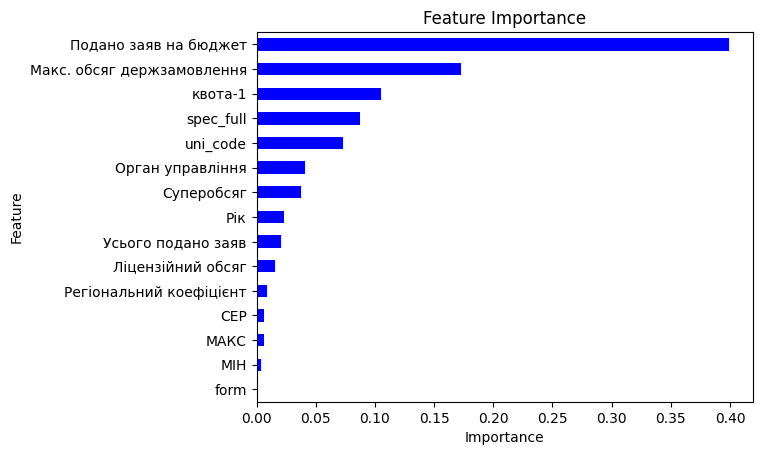

In [4]:
xgb_regressor1 = XGBRegressor(tree_method='exact', learning_rate=0.1, max_depth=5, n_estimators=5000, seed=1, validate_parameters=False)
xgb_regressor1.fit(X_train_std, y_train)

y_pred = xgb_regressor1.predict(X_test_std)
print_results(y_test, y_pred)

importances2 = pd.Series(xgb_regressor1.feature_importances_, index=X_train.columns)
importances2.sort_values(ascending=True, inplace=True)
importances2.plot.barh(color='blue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

MSE: 60.20506195903712 	R2 score: 0.9612001599498523
MSE: 63.198541330590324 	R2 score: 0.95927097796697

In [5]:
results_df2 = pd.read_csv('../readyDatasets/xgb_known_features_iter_5000_estimators.csv')

def calculate_mse(rate, depth, eta, gamma, lambd, alpha, x_train_n_features_std, x_test_n_features_std, y_train,
                  y_test):
    xgb_params = {'learning_rate': rate,
                  'max_depth': depth,
                  'n_estimators': 100,
                  'eta': eta,
                  'gamma': gamma,
                  'lambda': lambd,
                  'alpha': alpha,
                  'tree_method': 'exact',
                  'validate_parameters': False,
                  'seed': 1}
    xgb_regressor = XGBRegressor(**xgb_params)
    xgb_regressor.fit(x_train_n_features_std, y_train)
    y_pred_xgb = xgb_regressor.predict(x_test_n_features_std)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)

    return mse_xgb, depth, rate, eta, gamma, lambd, alpha


def run_experiment(features):
    global results_df2
    n_best_features = importances2.sort_values(ascending=False).head(features).keys()
    x_train_n_features = X_train.get(n_best_features)
    x_train_n_features_std = sc.fit_transform(x_train_n_features)

    x_test_n_features = X_test.get(n_best_features)
    x_test_n_features_std = sc.transform(x_test_n_features)

    best_depth = 0
    best_rate = 0
    best_eta = 0
    best_gamma = 0
    best_lambda = 0
    best_alpha = 0
    best_mse = 1000

    param_list = [
        (rate, depth, eta, gamma, lambd, alpha, x_train_n_features_std, x_test_n_features_std, y_train, y_test)
        for rate in [0.01, 0.05, 0.1, 0.15]
        for depth in [4, 5, 6, 7]
        for eta in [0.1 * i for i in range(1, 8)]
        for gamma in range(0, 21, 4)
        for lambd in [0, 1, 2]
        for alpha in [0, 0.04, 0.1]]

    results = Parallel(n_jobs=-1, verbose=1)(delayed(calculate_mse)(*params) for params in param_list)

    for mse_gbr, depth, rate, eta, gamma, lambd, alpha in results:
        if mse_gbr < best_mse:
            best_mse = mse_gbr
            best_depth = depth
            best_rate = rate
            best_eta = eta
            best_gamma = gamma
            best_lambda = lambd
            best_alpha = alpha

    results_df2 = results_df2.append({'Amount of features': features,
                                      'MSE': best_mse,
                                      'Rate': best_rate,
                                      'Depth': best_depth,
                                      'Eta': best_eta,
                                      'Gamma': best_gamma,
                                      'Lambda': best_lambda,
                                      'Alpha': best_alpha},
                                     ignore_index=True)
    print(features, 'best mse:', best_mse, end=', ')

In [8]:
for features in range(4, 15):
    start = time()
    run_experiment(features)
    print('time for the round:', (int(time() - start) / 60), 'min')
    results_df2.to_csv('../readyDatasets/xgb_known_features_iter_5000_estimators.csv', index=False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.1min


KeyboardInterrupt: 